In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import json
import time
import pytensor 
import pymc as pm
import arviz as az
import jax
import jax.numpy as jnp
import pyhf
import scipy.stats as sps
pyhf.set_backend('jax')

from jax import grad, jit, vmap, value_and_grad, random
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

# Building priors from auxiliary constraints

## Op

In [2]:
### Class that creates the model Op
class Op(pt.Op):
    itypes = [pt.dvector]  # Expects a vector of parameter values
    otypes = [pt.dvector]  # Outputs a vector of values (the model.expected_actualdata)

    def __init__(self, name, func):
        ## Add inputs as class attributes
        self.func = func
        self.name = name

    def perform(self, node, inputs, outputs):
        ## Method that is used when calling the Op
        (theta,) = inputs  # Contains my variables

        ## Calling input function (in our case the model.expected_actualdata)
        result = self.func(theta)

        ## Output values of model.expected_actualdata
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

## Model

In [9]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [5,6, 4],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 53],
     'modifiers': [
        ## Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [5, 5, 4]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 7, 9]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 8.7, 8]},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [55, 65, 67], 'lo_data': [45, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [55, 65, 66], 'lo_data': [45, 40, 44]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [55, 65, 60], 'lo_data': [45, 40, 39]}},
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [1.0, 2.0, 2.4],}
         ]},    
                                 
    ]},
    ],
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }
        ],}
)

### Observations
obs = model.expected_actualdata(model.config.suggested_init())

In [13]:
### Choose the right .json file
n = "DisplacedLeptons"

if n == "ttbar":
    with open("ttbar_ljets_xsec_inclusive_pruned.json") as serialized:
        spec = json.load(serialized)
    nBins = 37

if n == "DisplacedLeptons":
    with open("/Users/malinhorstmann/Documents/pyhf_pymc/PPC/SRee_SRmm_Srem.json") as serialized:
        spec = json.load(serialized)
    nBins = 3



### Create pyhf model from it
workspace = pyhf.Workspace(spec)

model = workspace.model()

### Observations
obs = workspace.data(model, include_auxdata=False)

## Inference

Note: 
- I stitch to `model.confif.par_map`
- Change of variables for the Poisson constraints needs to be implemented


In [14]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", jax.jit(model.expected_actualdata))

### Opening the PyMC model space
with pm.Model() as basic_model:

    ## Stitching
    unconstr_idx = np.concatenate([
        np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.unconstrained)
    ])
    norm_idx = np.concatenate([
        np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal)
    ])
    # poiss_idx = np.concatenate([
    #     np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_poisson)
    # ])
    
    target = np.array(np.concatenate([unconstr_idx, norm_idx]))
    # target = np.array(np.concatenate([unconstr_idx, norm_idx, poiss_idx]))
    print(target)
    

    ## Parameters
        # Unconstrained
    unconstr_pars = []
    unconstr_pars.extend(pm.Normal(f'{model.config.poi_name}', mu=[0], sigma=[1]))

        # Normal (histosys, lumi, staterror)
    norm_pars = []
    mu = []
    sigma = []
    for k,v in model.config.par_map.items():
        if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal):
            for i in model.constraint_model.viewer_aux.selected_viewer._partition_indices[model.config.auxdata_order.index(k)]:
                mu.append(model.config.auxdata[int(i)])
                sigma.append(model.constraint_model.constraints_gaussian.sigmas[int(i)])
    norm_pars.extend(pm.Normal('Normals', mu=mu, sigma=sigma))

        # Poisson (shapesys)
    # poiss_pars = []
    # alpha = []
    # beta = []
    # for k,v in model.config.par_map.items():
    #     if isinstance(v['paramset'], pyhf.parameters.constrained_by_poisson):
    #         for i in model.constraint_model.viewer_aux.selected_viewer._partition_indices[model.config.auxdata_order.index(k)]:
    #             alpha.append(model.config.auxdata[int(i)])
    #             beta.append(1)
    # poiss_pars.extend(pm.Gamma('Gammas', alpha=alpha, beta=beta))

    pars = np.concatenate([unconstr_pars, norm_pars])
    # pars = np.concatenate([unconstr_pars, norm_pars, poiss_pars])
    final = pt.as_tensor_variable(pars[target.argsort()].tolist())
    
    ## Model for the model.expected_actualdata()
        # Attention: pm.Poisson breaks down, as \lambda < 0 occasionally if mu=0.0
    main = pm.Normal("main", mu=mainOp(final), observed=obs)

    ## Sampling
    post_data = pm.sample(500)
    prior_data = pm.sample_prior_predictive(500)
    post_pred = pm.sample_posterior_predictive(post_data)

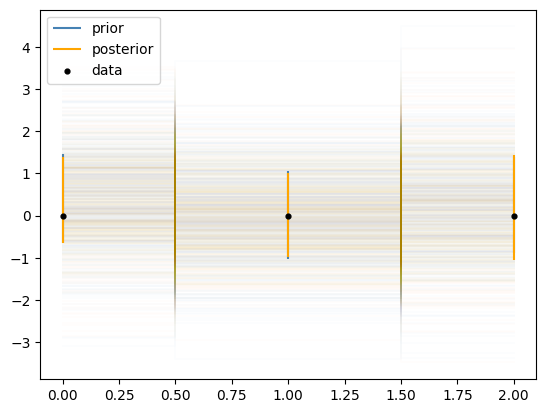

In [15]:
### Plotting ...
    ## Prior predictive
plt.step(np.linspace(0,nBins-1,nBins),prior_data.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_data.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label="prior");
    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label="posterior")
    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

# plt.text(0.5, 4.25, 'Priors: build from the auxiliary data, \nusing conjugate priors.')
# # plt.text(10, 1699999, 'Priors: build from the auxiliary data, \nusing conjugate priors.')
# plt.title(f'Prior / posterior checks for {n}')

# ax = plt.gca()
# ax.set_ylim([-2099999, 2090999])

# plt.savefig(f'{n}.pdf')

(-2099999.0, 2090999.0)

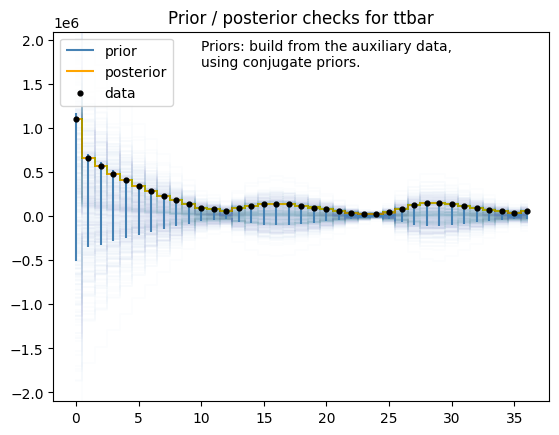

In [143]:
### Plotting ...
    ## Prior predictive
plt.step(np.linspace(0,nBins-1,nBins),prior_data.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_data.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label="prior");
    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label="posterior")
    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

# plt.text(0.5, 4.25, 'Priors: build from the auxiliary data, \nusing conjugate priors.')
plt.text(10, 1699999, 'Priors: build from the auxiliary data, \nusing conjugate priors.')
plt.title(f'Prior / posterior checks for {n}')

ax = plt.gca()
ax.set_ylim([-2099999, 2090999])

# plt.savefig(f'{n}.pdf')

## Testing the parameter priors

In [268]:
### Extracting the input values from the auxiliary data
    ## Stitching
unconstr_idx = np.concatenate([
    np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.unconstrained)
])
norm_idx = np.concatenate([
    np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal)
])
# poiss_idx = np.concatenate([
#     np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_poisson)
# ])

target = np.array(np.concatenate([unconstr_idx, norm_idx]))
# target = np.array(np.concatenate([unconstr_idx, norm_idx, poiss_idx]))

    ## Unconstrained
poiMu = [1]
poiSigma = [0]

    ## Normals
mu = []
sigma = []
for k,v in model.config.par_map.items():
    if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal):
        for i in model.constraint_model.viewer_aux.selected_viewer._partition_indices[model.config.auxdata_order.index(k)]:
            mu.append(model.config.auxdata[int(i)])
            sigma.append(model.constraint_model.constraints_gaussian.sigmas[int(i)])

    ### Poisson 
# alpha = []
# beta = []
# for k,v in model.config.par_map.items():
#     if isinstance(v['paramset'], pyhf.parameters.constrained_by_poisson):
#         for i in model.constraint_model.viewer_aux.selected_viewer._partition_indices[model.config.auxdata_order.index(k)]:
#             alpha.append(model.config.auxdata[int(i)])
#             beta.append(1)

### Stitching the input vectors
muN = np.concatenate([mu])[norm_idx.argsort()].tolist()
sigmaN = np.concatenate([sigma])[norm_idx.argsort()].tolist()

# alphaP = np.concatenate([alpha])[poiss_idx.argsort()].tolist()
# betaP = np.concatenate([beta])[poiss_idx.argsort()].tolist()

### Cross-Check stitched parameter order with the par_map
# pars = np.concatenate([poiMu, mu, alpha])
pars = np.concatenate([poiMu, mu])
final = pars[target.argsort()].tolist()
print(final)
print('.....')
model.config.par_map

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
.....


{'JET_JER_DataVsMC': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x295a38340>},
 'JET_JER_NP1': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x295a38f40>},
 'JET_JER_NP2': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x280c81d90>},
 'JET_JER_NP3': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x295a4a100>},
 'JET_JER_NP4': {'slice': slice(4, 5, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x293fbc310>},
 'JET_JER_NP7': {'slice': slice(5, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2a2d56b80>},
 'weight_bTagSF_MV2c10_Continuous_eigenvars_C_0': {'slice': slice(6, 7, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2a2d561f0>},
 'weight_bTagSF_MV2c10_Continuous_eigenvars_C_1': {'slice': slice(7, 8, None),


In [273]:
sampledPOI = sps.uniform(-10, 20).rvs((1000, 1))
sampledN = sps.norm(muN, sigmaN).rvs((1000, len(muN)))
# sampledP = sps.poisson(alphaP, betaP).rvs((1000, len(alphaP)))

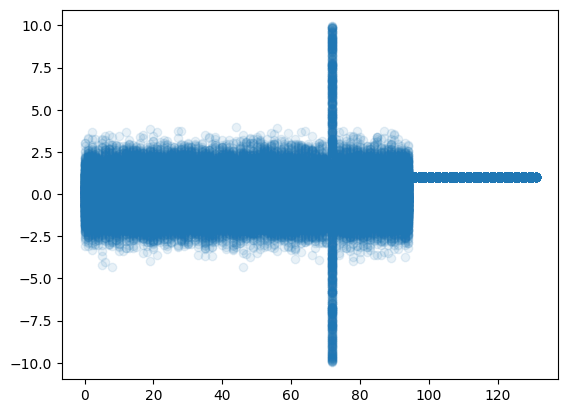

In [274]:
# all = np.concatenate([sampledPOI, sampledN, sampledP], axis=-1)
all = np.concatenate([sampledPOI, sampledN], axis=-1)
final = all[..., target.argsort()]
# par_position = np.tile(np.arange(1+len(muN)+len(alphaP)).reshape(1,-1), (1000, 1))
par_position = np.tile(np.arange(1+len(muN)).reshape(1,-1), (1000, 1))
plt.scatter(par_position, final, alpha = 0.1)

In [6]:
model.constraint_model.constraints_gaussian.normal_data

Array([ 0,  1,  2,  3, 13, 14, 15], dtype=int64)

In [4]:
model.constraint_model.constraints_poisson.poisson_data

Array([ 4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)